In [68]:
import sys
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u #currently not used
import mask_obj_node as maskNode
import mask_obj_node_tree as maskTree
import process_cube
fil_finder_dir = '/Users/larryli/Documents/CC/16-17/research/GALFA_filfind/fil_finder'
sys.path.append(fil_finder_dir)
import filfind_class as filfind
%matplotlib inline
print "YES"

YES


In [248]:
cube_dir = '../data/'
cube_name = 'usharpbg30.fits'

'''
v_range = [12,21]
y_range = [850, 1120]
y_dim = y_range[1] - y_range[0]
x_range = [2230, 2600]
x_dim = x_range[1] - x_range[0]
'''

v_range = [8,9]
y_range = [750, 950]
y_dim = y_range[1] - y_range[0]
x_range = [1900, 2600]
x_dim = x_range[1] - x_range[0]

In [249]:
full_cube, hdr = fits.getdata(cube_dir + cube_name, header=True)

# full cube dimentions
full_cube_shape = full_cube.shape
full_v_channel_count = full_cube_shape[0]
full_y_pixel_count = full_cube_shape[1]
full_x_pixel_count = full_cube_shape[2]

# cut cube based on provided x&y dimentions
cut_cube = full_cube[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]

	There are 36 velocity channels in total
	The full image is 2600 by 1150 pixels
	Processing x=[1900, 2600], y=[750, 950] in v=[8, 9]

	working on velocity slice 8
number of objects: 11
saving struct at pickled_dicts/usharpbg30[8, 9][1900, 2600][750, 950].p


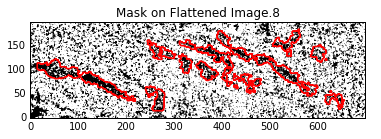

In [250]:
reload(filfind)
reload(process_cube)

pickle_save_path = process_cube.process_cube_filfind_struct(cube_dir, cube_name, v_range, x_range, y_range)

In [347]:
recover_pickle_path1 = 'pickled_dicts/usharpbg30[0, 36][1300, 2600][600, 1150].p'
recover_pickle_path2 = 'pickled_dicts/usharpbg30[5, 12][1600, 2400][600, 1100].p'
recover_pickle_path3 = 'pickled_dicts/usharpbg30[6, 10][1900, 2600][750, 950].p'
recover_pickle_path4 = 'pickled_dicts/usharpbg30[8, 10][1900, 2600][750, 950].p'
recover_pickle_path5 = 'pickled_dicts/usharpbg30[8, 9][1900, 2600][750, 950].p'

recover_path = recover_pickle_path1

In [348]:
#recover pickle
nodes_by_v_slice = pickle.load( open(recover_path, 'rb'))

In [349]:
reload(maskNode)
reload(maskTree)

<module 'mask_obj_node_tree' from 'mask_obj_node_tree.pyc'>

In [350]:
def newTreeFromNode(node):
    print "\t   NEW TREE!"
    node.visited = True
    new_tree = maskTree.MaskObjNodeTree(node)
    return new_tree

In [351]:
# this assume the input tree is just the root
def findAllChildren(tree, overlap_thresh, reverse = False):
    start_v = tree.root_v_slice
    adv = 1
    if reverse:
        adv = -1
    v_slice = start_v + adv
    while v_slice < v_range[1]:
        if v_slice not in nodes_by_v_slice or len(nodes_by_v_slice[v_slice]) == 0:
            tree.has_ended = True
            break
        else:
            children_added = []
            print tree.getLastNode().corners
            #sort keys in descending valye
            for i in sorted(nodes_by_v_slice[v_slice].keys(), reverse=True):
                if nodes_by_v_slice[v_slice][i].visited == False:
                    if tree.getLastNode().checkMaskOverlap(nodes_by_v_slice[v_slice][i], overlap_thresh):
                        children_added.append(i)
                        print nodes_by_v_slice[v_slice][i].corners
                    
            print "\t\t %d children found on slice %d" % (len(children_added), v_slice)
            if len(children_added) == 1:
                nodes_by_v_slice[v_slice][children_added[0]].visited = True
                print "\t\t\t %d - %d marked as visited" % (v_slice, children_added[0])
                tree.addNode(nodes_by_v_slice[v_slice][children_added[0]])
                v_slice += adv
                continue
            elif len(children_added) > 1:
                first_node = nodes_by_v_slice[v_slice][children_added[0]]
                print "\t\t\t %d - %d marked as visited" % (v_slice, children_added[0])
                for j in children_added:
                    first_node.mergeNode(nodes_by_v_slice[v_slice][j])
                    nodes_by_v_slice[v_slice][j].visited = True
                first_node.visited = True
                tree.addNode(first_node)
                v_slice += adv
                continue
            elif len(children_added) == 0:
                tree.has_ended = True
                break
                    
    return tree

In [352]:
def findNewFullTree(root_node, overlap_thresh, reverse=False):
    new_tree = newTreeFromNode(root_node)
    new_tree = findAllChildren(new_tree, overlap_thresh, reverse=reverse)
    
    #print new_tree.root_node.corners
    return new_tree

In [353]:
nodes_by_tree = []
overlap_thresh = .50

reverse_find = True

for v in sorted(nodes_by_v_slice.keys(), reverse=reverse_find):
    if v not in nodes_by_v_slice:
        print "\n\nSOMETHING WENT WRONG"
        sys.exit()
        
    print "on v slice %d" % v
    
    if v == sorted(nodes_by_v_slice.keys())[-1]:
        for i in sorted(nodes_by_v_slice[v].keys(), reverse=True):
            print "\ton mask %d" % i
            
            new_full_tree = findNewFullTree(nodes_by_v_slice[v][i], overlap_thresh, reverse=reverse_find)
            nodes_by_tree.append(new_full_tree)
            
    else:
        for i in sorted(nodes_by_v_slice[v].keys(), reverse=True):
            print "\ton mask %d" % i
            
            if nodes_by_v_slice[v][i].visited == True:
                print "\t   visited"
                continue
            else:
                new_full_tree = findNewFullTree(nodes_by_v_slice[v][i], overlap_thresh, reverse=reverse_find)
                nodes_by_tree.append(new_full_tree)

on v slice 35
	on mask 1178
	   NEW TREE!
	on mask 863
	   NEW TREE!
	on mask 726
	   NEW TREE!
	on mask 711
	   NEW TREE!
	on mask 694
	   NEW TREE!
	on mask 622
	   NEW TREE!
	on mask 606
	   NEW TREE!
	on mask 603
	   NEW TREE!
	on mask 594
	   NEW TREE!
	on mask 543
	   NEW TREE!
	on mask 517
	   NEW TREE!
on v slice 34
	on mask 1210
	   NEW TREE!
	on mask 962
	   NEW TREE!
	on mask 907
	   NEW TREE!
	on mask 860
	   NEW TREE!
	on mask 852
	   NEW TREE!
	on mask 829
	   NEW TREE!
	on mask 791
	   NEW TREE!
	on mask 771
	   NEW TREE!
	on mask 705
	   NEW TREE!
	on mask 683
	   NEW TREE!
	on mask 672
	   NEW TREE!
	on mask 671
	   NEW TREE!
	on mask 660
	   NEW TREE!
	on mask 653
	   NEW TREE!
	on mask 635
	   NEW TREE!
	on mask 617
	   NEW TREE!
	on mask 578
	   NEW TREE!
	on mask 576
	   NEW TREE!
	on mask 573
	   NEW TREE!
	on mask 557
	   NEW TREE!
on v slice 33
	on mask 1704
	   NEW TREE!
	on mask 741
	   NEW TREE!
	on mask 695
	   NEW TREE!
	on mask 679
	   NEW TREE!
	on mask 6

In [354]:
def createIntIntensityMap(v_min, v_max):
    int_intensity = np.zeros((y_dim, x_dim))

    print int_intensity.shape
    print v_min, v_max
    for c in range(0, int_intensity.shape[0]):
        for r in range(0, int_intensity.shape[1]):
            intensity_sum = 0.0
            for v in range(v_min, v_max):
                intensity_sum += cut_cube[v,c,r]
            int_intensity[c,r] = intensity_sum
            
    return int_intensity

In [355]:
print len(nodes_by_tree)

for tree in nodes_by_tree:
    if tree.length > 2:
        print "yes"

1167
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


lenth of 7
977
(200, 700)
2 9


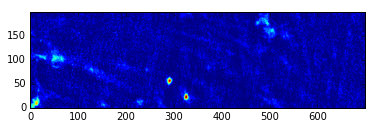

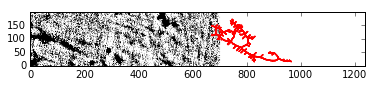

lenth of 10
978
(200, 700)
-1 9


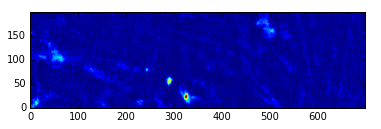

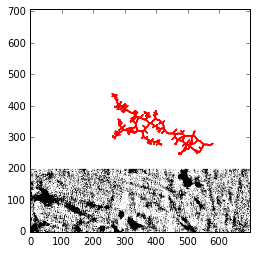

lenth of 10
979
(200, 700)
-1 9


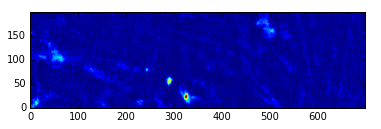

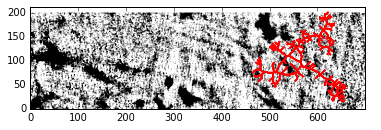

lenth of 10
980
(200, 700)
-1 9


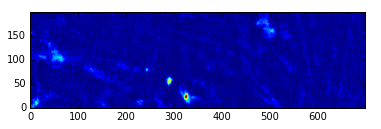

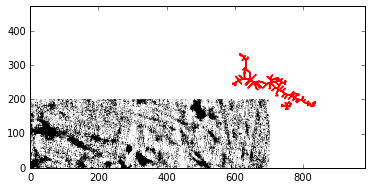

lenth of 10
981
(200, 700)
-1 9


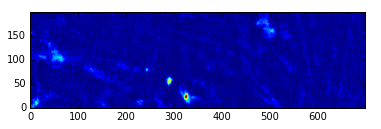

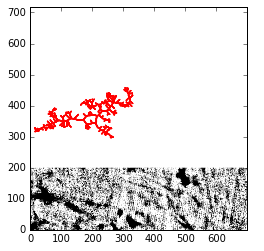

lenth of 10
982
(200, 700)
-1 9


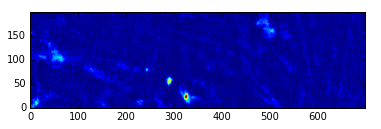

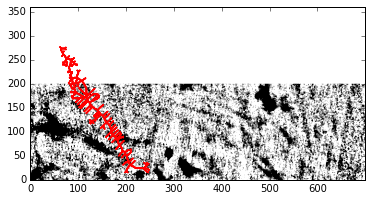

lenth of 6
983
(200, 700)
3 9


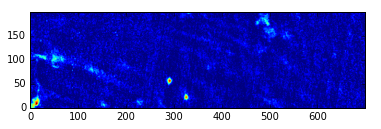

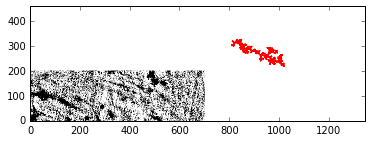

lenth of 9
984
(200, 700)
0 9


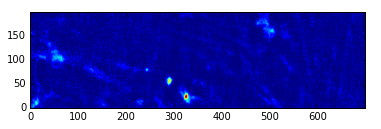

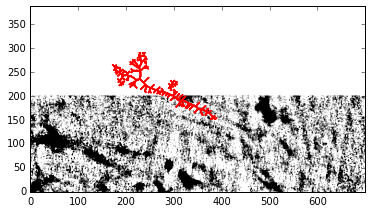

lenth of 10
985
(200, 700)
-1 9


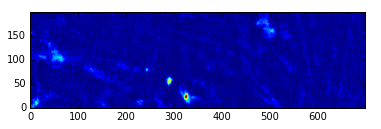

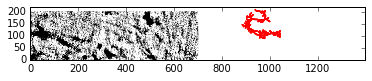

lenth of 4
986
(200, 700)
5 9


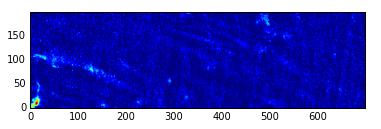

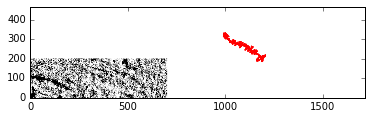

lenth of 10
987
(200, 700)
-1 9


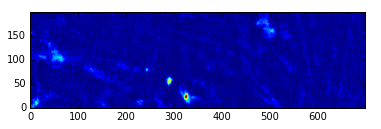

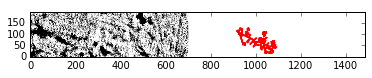

lenth of 6
988
(200, 700)
3 9


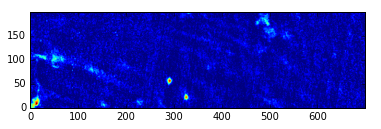

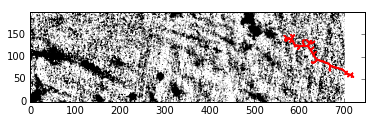

lenth of 7
991
(200, 700)
2 9


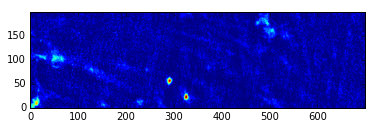

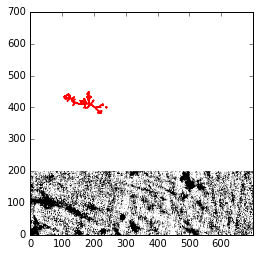

lenth of 4
992
(200, 700)
5 9


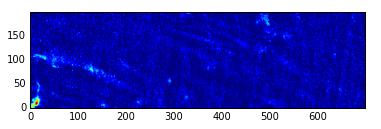

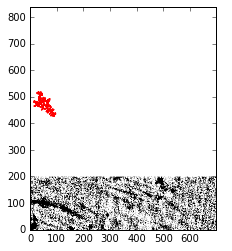

lenth of 10
993
(200, 700)
-1 9


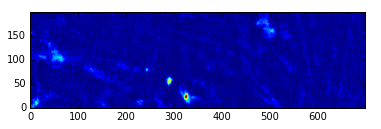

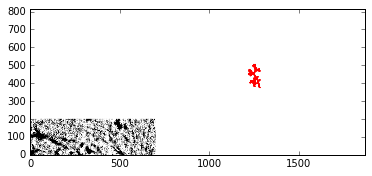

lenth of 8
994
(200, 700)
1 9


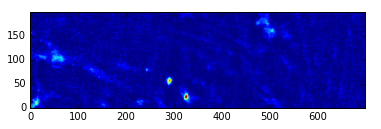

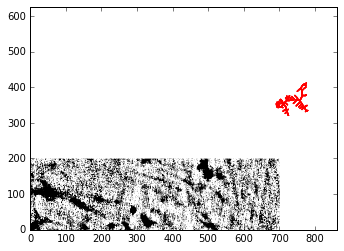

lenth of 10
995
(200, 700)
-1 9


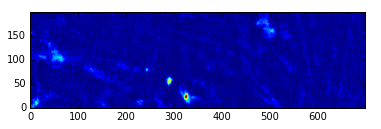

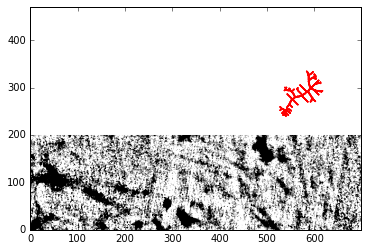

lenth of 10
997
(200, 700)
-1 9


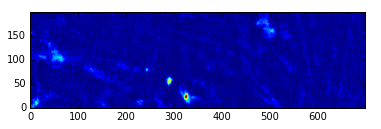

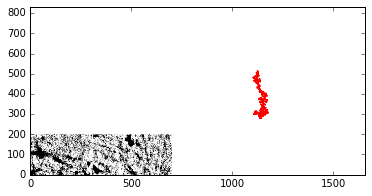

lenth of 4
999
(200, 700)
5 9


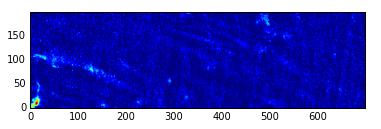

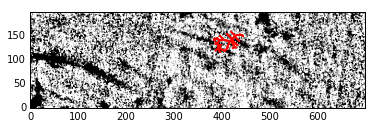

lenth of 4
1000
(200, 700)
5 9


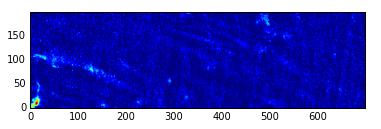

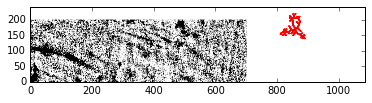

lenth of 10
1001
(200, 700)
-1 9


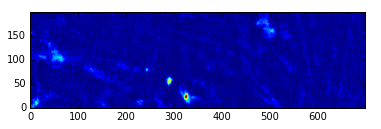

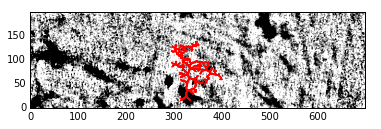

lenth of 7
1004
(200, 700)
2 9


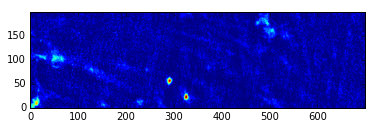

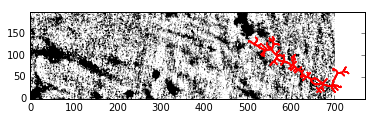

lenth of 10
1008
(200, 700)
-1 9


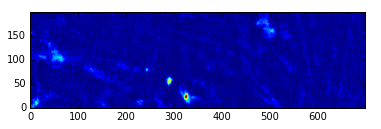

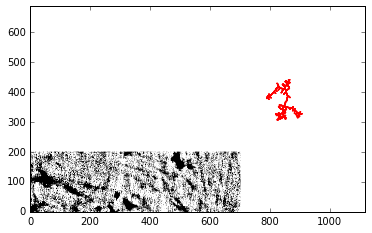

lenth of 10
1009
(200, 700)
-1 9


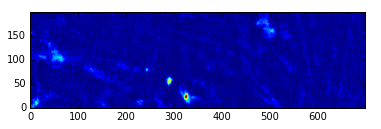

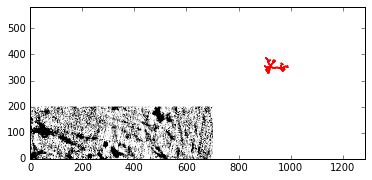

lenth of 7
1010
(200, 700)
2 9


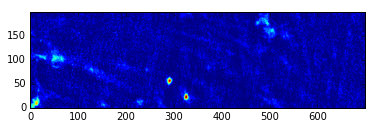

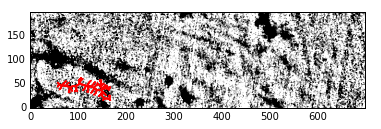

lenth of 3
1011
(200, 700)
6 9


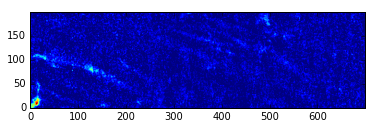

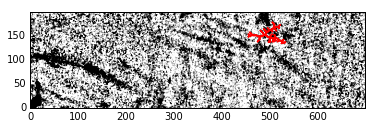

lenth of 10
1018
(200, 700)
-1 9


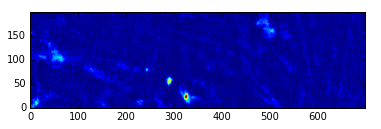

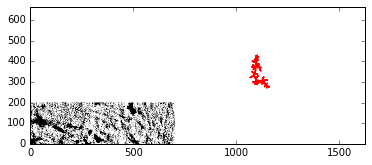

lenth of 10
1019
(200, 700)
-1 9


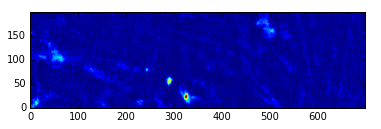

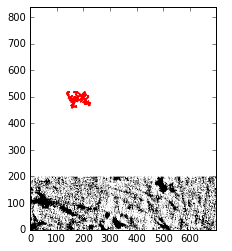

lenth of 5
1022
(200, 700)
4 9


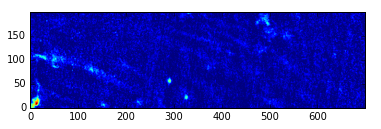

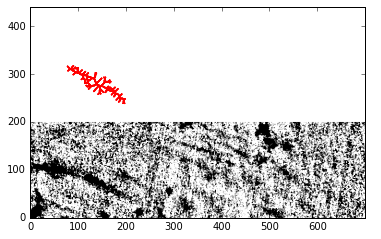

lenth of 10
1024
(200, 700)
-1 9


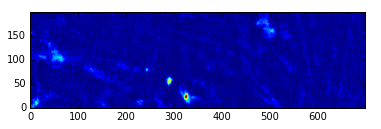

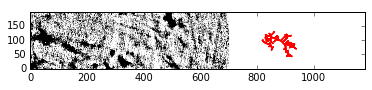

lenth of 3
1034
(200, 700)
6 9


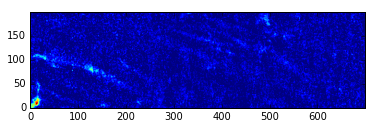

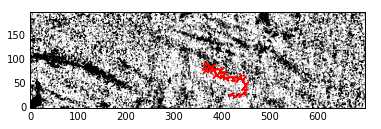

lenth of 3
1035
(200, 700)
5 8


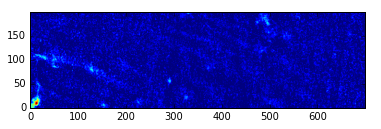

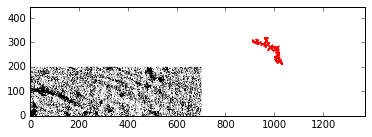

lenth of 9
1037
(200, 700)
-1 8


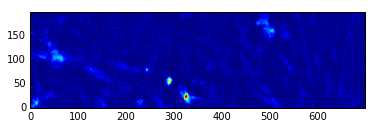

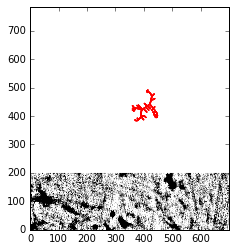

lenth of 3
1040
(200, 700)
5 8


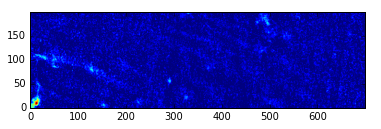

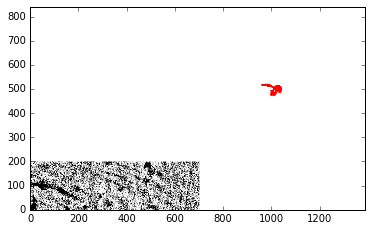

lenth of 6
1046
(200, 700)
2 8


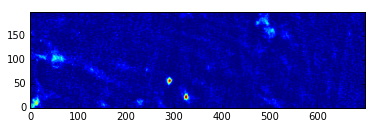

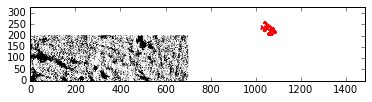

lenth of 6
1049
(200, 700)
2 8


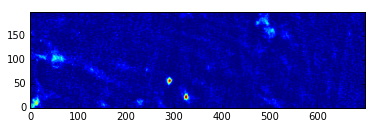

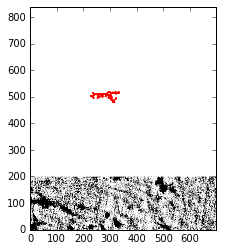

lenth of 3
1051
(200, 700)
5 8


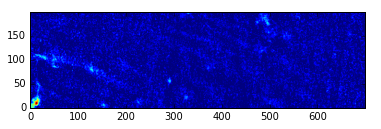

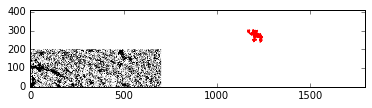

lenth of 5
1059
(200, 700)
2 7


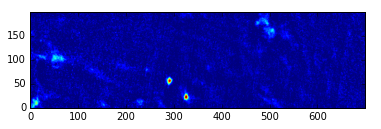

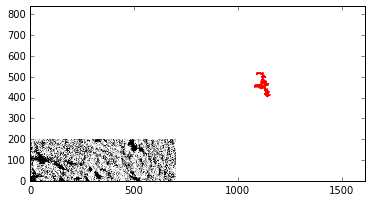

lenth of 7
1060
(200, 700)
0 7


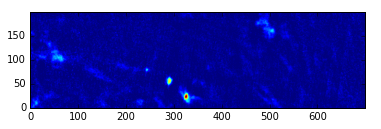

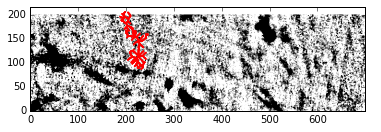

lenth of 4
1064
(200, 700)
3 7


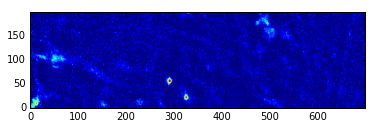

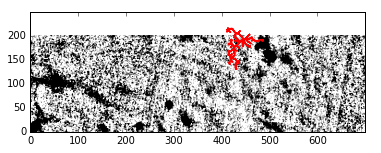

lenth of 3
1067
(200, 700)
4 7


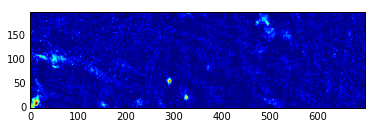

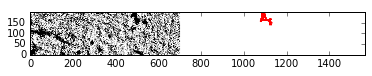

lenth of 7
1070
(200, 700)
-1 6


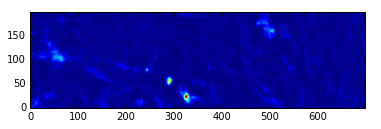

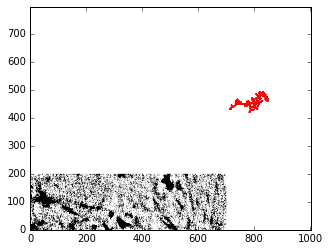

lenth of 7
1074
(200, 700)
-1 6


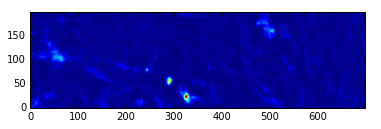

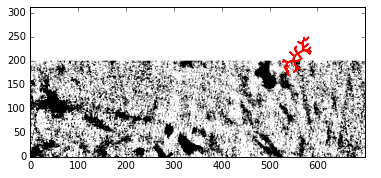

lenth of 7
1076
(200, 700)
-1 6


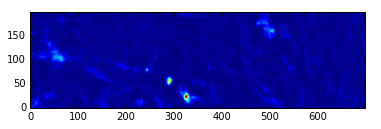

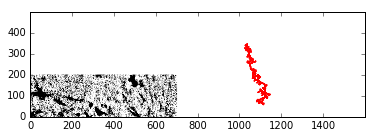

lenth of 7
1077
(200, 700)
-1 6


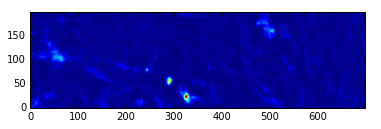

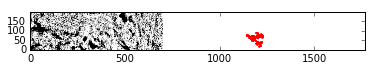

lenth of 6
1090
(200, 700)
-1 5


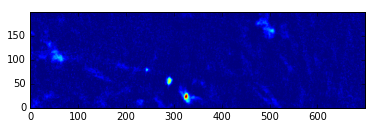

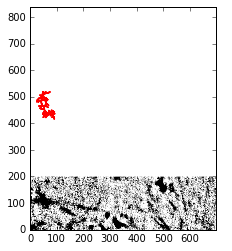

lenth of 6
1094
(200, 700)
-1 5


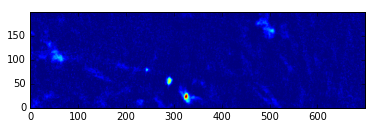

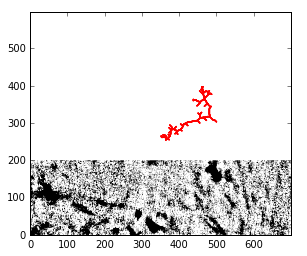

lenth of 6
1099
(200, 700)
-1 5


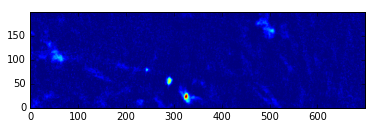

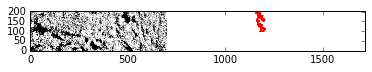

lenth of 6
1100
(200, 700)
-1 5


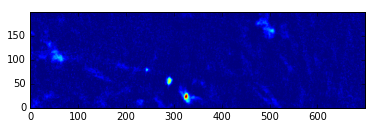

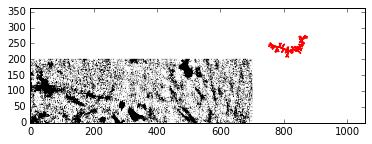

lenth of 4
1103
(200, 700)
0 4


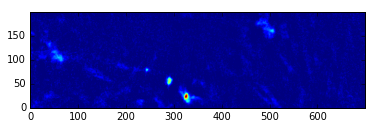

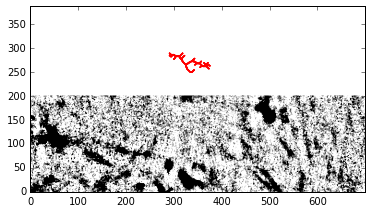

lenth of 3
1106
(200, 700)
1 4


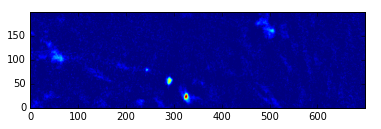

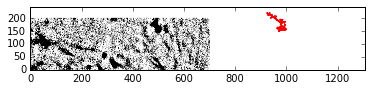

lenth of 4
1110
(200, 700)
0 4


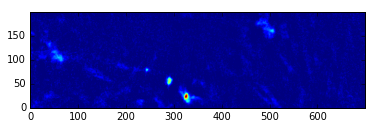

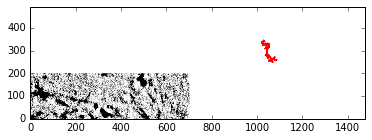

lenth of 5
1112
(200, 700)
-1 4


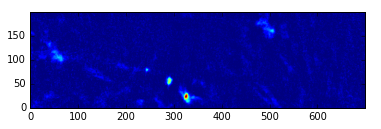

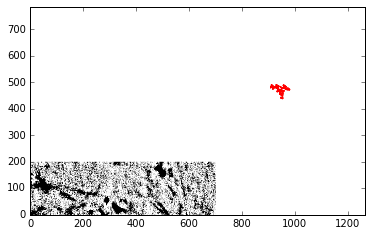

lenth of 4
1117
(200, 700)
-1 3


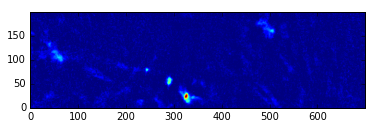

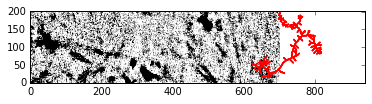

lenth of 4
1118
(200, 700)
-1 3


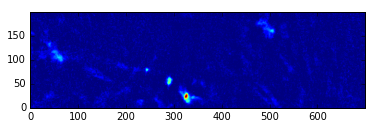

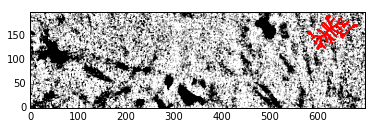

lenth of 3
1119
(200, 700)
0 3


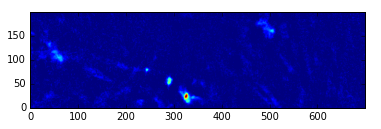

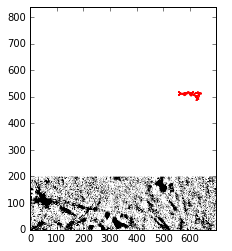

lenth of 4
1122
(200, 700)
-1 3


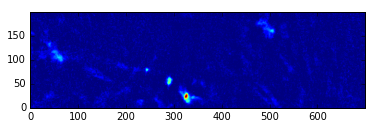

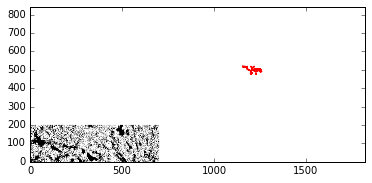

lenth of 4
1124
(200, 700)
-1 3


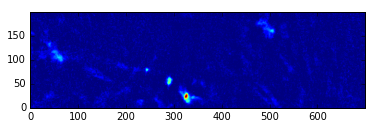

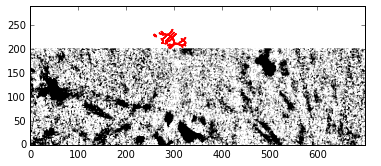

lenth of 3
1125
(200, 700)
0 3


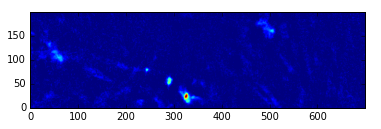

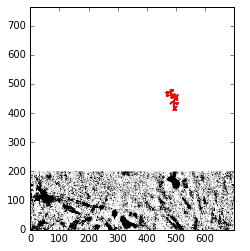

lenth of 4
1126
(200, 700)
-1 3


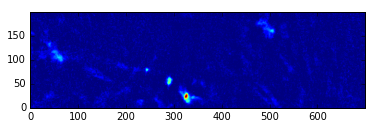

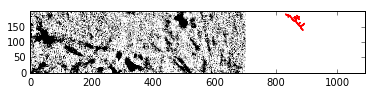

lenth of 3
1127
(200, 700)
0 3


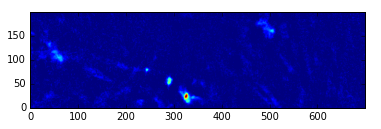

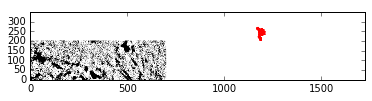

lenth of 3
1128
(200, 700)
0 3


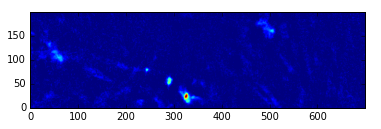

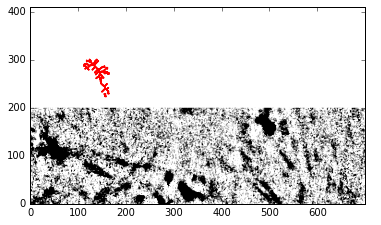

lenth of 3
1132
(200, 700)
-1 2


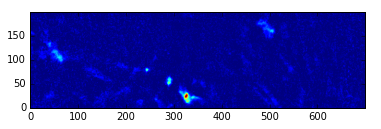

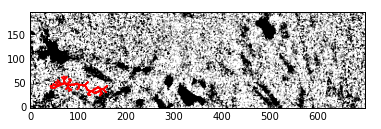

lenth of 3
1133
(200, 700)
-1 2


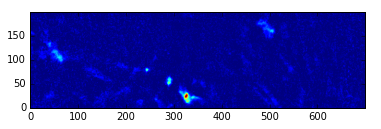

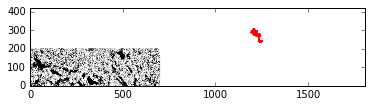

lenth of 3
1134
(200, 700)
-1 2


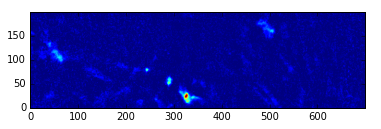

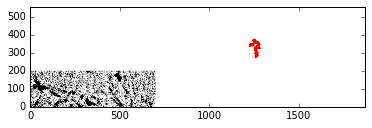

lenth of 3
1135
(200, 700)
-1 2


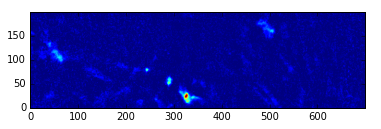

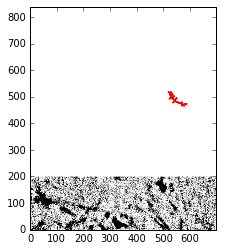

lenth of 3
1141
(200, 700)
-1 2


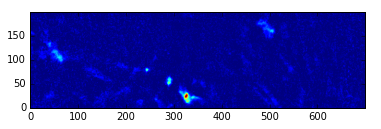

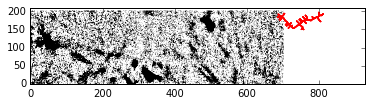

lenth of 3
1142
(200, 700)
-1 2


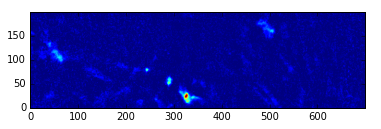

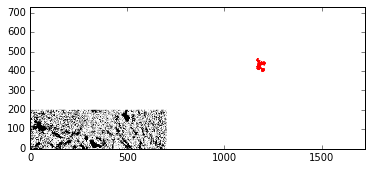

In [356]:
for tree in nodes_by_tree:
    if tree.length < 3:
        continue
    else:
        print "lenth of %d" % tree.length
        print nodes_by_tree.index(tree)
        intensity_map = createIntIntensityMap(tree.root_v_slice-tree.length, tree.root_v_slice)
        imgplot = plt.imshow(intensity_map, origin='lower')
        plt.show()
        fil_tree = filfind.fil_finder_2D(intensity_map, header=hdr, beamwidth=10.0, glob_thresh=20,
                                 distance=100, flatten_thresh=95, standard_width=1.1,
                                 size_thresh=1000, mask = tree.root_node.expandMask([[0,0],[x_dim, y_dim]]))
        #fil_tree.create_mask(verbose=True, regrid=False, border_masking=True)
        fil_tree.medskel(verbose=True)
